In [5]:
import random
import numpy as np
import copy
import gym
from gym.spaces import Box, Discrete
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

# Installation (Mac M1)
python version 3.8

- update pip "pip install --upgrade pip"

- install pytorch: "pip3 install torch torchvision"

- the aim of the project is to implement a customized Reinforcement Learning environment based on the Gym library 
- and then teach an DQN the rules of the game

- we start of by defining the environment

In [6]:
class Qwixx_Env_3(gym.Env):
    
        #metadata = {'render.modes': ['human']}
        def __init__(self):
            super( Qwixx_Env_3, self).__init__()
            self.action_space = Discrete(3) #pass, make a cross at the first or second round
            self.observation_space = Box(low=0, high=12, shape= (26,), dtype=int)
            self.score_board = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]).astype(int)
            self.current_step = 1
            info = {}
           
            done = False
            
        def reset(self):
            done = False
            self.current_step = 1
            self.score_board = np.array([[1, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0.],
                                        [1, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]).astype(int)
            info = {}
            return self.score_board.reshape(26,)
        def step(self, action):
            reward = -0.01
            done = False
            info = {}
            possible_sums = self.dice()
            self.score_board[0][1] = possible_sums["white_red"]
            self.score_board[1][1] = possible_sums["white_yellow"]
            if action == 0:
                reward = self.reward_back(action, possible_sums["white_red"])
                self.update(action, possible_sums["white_red"])
            elif action == 1:
                reward = self.reward_back(action, possible_sums["white_yellow"]) 
                self.update(action, possible_sums["white_yellow"])
            elif action == 2: 
                reward = -0.05 # tested -0.25, 0.25, -0.05
                self.score_board = self.score_board
            else: 
                raise Exception
            self.current_step += 1
            if self.current_step == 10 :
                done =True
            if (self.score_board[0][12] != 0) or (self.score_board[1][12] != 0):
                reward = 1.0
                done = True
            # one function that gives the dice values
            # one that converts it two the sums
            # one that based on the action and the sums gives a reward -0.01 and -0.5
            return self.score_board.astype(int).reshape(26,), reward, done, info
        def dice(self):
            white_dice = np.random.randint(1,7)
            red_dice = np.random.randint(1,7)
            yellow_dice = np.random.randint(1,7)
            possible_sums = {"white_red": white_dice + red_dice, "white_yellow": white_dice + yellow_dice}

            return possible_sums

        def reward_back(self, action, current_sum):
            #index_current = np.where(self.score_board[action] == self.current_step)[0][0]
            index_last = np.max(np.nonzero(self.score_board[action]))
            if (index_last < current_sum):
                reward = 0.5
            else: 
                reward = -1. #tested -0.7, -1.
            return reward
        def update(self, action, current_sum):
            self.score_board[action][current_sum] = 1
            
        def finished(self):
            if (self.score_board[0][11] != 0) or (self.score_board[1][11] != 0):
                reward = 1.0
                done = True
                return done
            else:
                done = False
        def render(self):
            print(self.score_board)

- the Gym based environment returns numpy array, as our plan is to feed the states into a neuronal network approximating the Q-values, we must convert the returned quanities into Torch tensors
- the following Wrapper does the job for us

In [3]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

- now we can create an object of the environment class and then wrap it

In [7]:
qwixx3 = Qwixx_Env_3()
qwixx3.reset()
env = PreprocessEnv(qwixx3)

- let's now try the environment with a random agent

In [18]:
qwixx2 = Qwixx_Env_3()
qwixx2.reset()
env2 = PreprocessEnv(qwixx2)
obs = env2.reset()

reward = 0
done = False
while not done:  
          action = torch.randint(0, 2, (1,1))
          obs, reward, done, info = env2.step(action)
          print(f"action taken {action} with reward {reward}")
          

action taken tensor([[1]]) with reward tensor([[0.5000]])
action taken tensor([[0]]) with reward tensor([[0.5000]])
action taken tensor([[1]]) with reward tensor([[-1.]])
action taken tensor([[0]]) with reward tensor([[-1.]])
action taken tensor([[1]]) with reward tensor([[-1.]])
action taken tensor([[0]]) with reward tensor([[-1.]])
action taken tensor([[1]]) with reward tensor([[1.]])


In [ ]:
- we can see by randomly taking action the agent gets punishment of  -1., which means it is not fullfilling the rules
of the game

- No let's see if with a DQN agent we can teach the agent how to play according to the rules of the game, that we set
- we first need a neuronal network that approximate the Q-values based on a given state and action, the states are torch tensors of dimension (#batch x 26)   
- then we define a epsilon-greedy policy

In [19]:
num_actions = 3
state_dim = 13
num_bord_rows = 2
q_network = nn.Sequential(
    nn.Linear(state_dim*num_bord_rows, 256), # testet 128 , 256
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions))

In [20]:
target_q_network = copy.deepcopy(q_network).eval()

In [21]:
def policy(state, epsilon=0.):
    num_actions = 3
    if torch.rand(1) < epsilon:
        return torch.randint(0, 2, (1,1)) # change accrodingly to action space, start/end value, dimension
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

- now we come to the heart of the Deep Q alogrithm
- we define a class for the replay memory, of which we will draw sample for optimizing the weights of the Q-network
- and we define a function that implements deep Q-learning

In [22]:
class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [23]:
def deep_q_learning(q_network, policy, episodes, 
                    alpha=0.00001, batch_size=32, gamma=0.99, epsilon=0.2):
    
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)              
                qsa_b = q_network(state_b).gather(1, action_b)
                
                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                stats['MSE Loss'].append(loss)  
                
            state = next_state
            ep_return += reward.item()
            
        
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

In [34]:
stats = deep_q_learning(q_network, policy, 500)

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 194.93it/s]


- and now we can print the results of the returns and play one episode with our trained agent

Text(0, 0.5, 'Return')

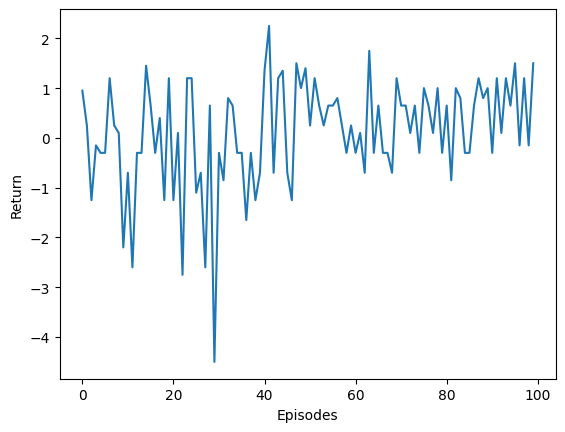

In [37]:
plt.plot(stats['Returns'][0:100])
plt.xlabel("Episodes")
plt.ylabel("Return")

In [36]:
qwixx4 = Qwixx_Env_3()
qwixx4.reset()
env3 = PreprocessEnv(qwixx4)
obs = env3.reset()

reward = 0
done = False
while not done:  
          action = policy(obs)
          obs, reward, done, info = env3.step(action)
          print(f"action taken {action} with reward {reward}")



action taken tensor([[1]]) with reward tensor([[0.5000]])
action taken tensor([[2]]) with reward tensor([[-0.0500]])
action taken tensor([[0]]) with reward tensor([[0.5000]])
action taken tensor([[0]]) with reward tensor([[0.5000]])
action taken tensor([[2]]) with reward tensor([[-0.0500]])
action taken tensor([[2]]) with reward tensor([[-0.0500]])
action taken tensor([[2]]) with reward tensor([[-0.0500]])
action taken tensor([[2]]) with reward tensor([[-0.0500]])
action taken tensor([[2]]) with reward tensor([[-0.0500]])


- Voila, we successfully taught the rules of our game to an Deep Q-learing agent
- we achieved convergence in the trainging and the agent is not punished by -1. for violatinge the rules